Description

In this file we introduce a baseline, with which we can compare our one-year-ahead forecasts from future_year_pred.ipynb. For the baseline, the current-year undernourishment of a given country and year serves as our one-year-ahead forecast. We observe, that this method performs stronger than the random forest model, that is based on our self-created dataset. To compare the two we use their respective root mean squared errors. Future work includes checking longer time frames for prediction than one year.

In [149]:
# importing general necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
# models that are fitted on the data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [150]:
# importing the dataset and making some adjustments so it works with the model and the time series split
df = pd.read_csv("../4)Data/combined_dataset_temp.csv").drop(columns=["Unnamed: 0", "GAUL", "M49"])
df["Casualties"] = df["Casualties"].fillna(0)
df["Undernourishment (%)"] = df["Undernourishment (%)"].replace({"<2.5": 0})
df["Undernourishment (%)"] = pd.to_numeric(df["Undernourishment (%)"]).shift(periods=-1)
df = df.drop(index=df.index[19::20])
df = df.dropna().sort_values("Year")
df = df.drop(df[(df.Area == "Montenegro") | (df.Area == "Serbia")].index)

In [151]:
# Creating training and test data, but not randomly splitting (roughly two years get excluded) and scaling
sc_x = StandardScaler()
sc_y = StandardScaler()

df_model = df.drop(columns=["Area", "Year"])

df_model_x = sc_x.fit_transform(df_model[["GDP (MUSD)", "GNI (MUSD)", "Food Prod. Index", "Temperature", "Precipitation", "NDVI", "Casualties"]])
df_model_x = pd.DataFrame(df_model_x, columns=["GDP (MUSD)", "GNI (MUSD)", "Food Prod. Index", "Temperature", "Precipitation", "NDVI", "Casualties"])

df_model_y = sc_y.fit_transform(df_model["Undernourishment (%)"].array.reshape(-1, 1))
df_model_y = pd.DataFrame(df_model_y, columns=["Undernourishment (%)"])

y_train = df_model_y["Undernourishment (%)"].iloc[:-152]
X_train = df_model_x.iloc[:-152]

y_test = df_model_y["Undernourishment (%)"].iloc[-152:]
X_test = df_model_x.iloc[-152:]

In [152]:
# Cross Validated Score of the Random Forest Model
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5, test_size=304)
scores = cross_val_score(model, X_train, y_train, cv=tscv)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.75 accuracy with a standard deviation of 0.02


In [153]:
# Predicting the test data, after fitting the model on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

print("model score on training data:",model.score(X_train, y_train))
print("model score on test data:",model.score(X_test, y_test))

model score on training data: 0.9848796799302936
model score on test data: 0.7616826885379752


In [154]:
# making predictions and saving the results
res = pd.DataFrame()
res["Pred. Undernourishment"] = model.predict(X_test)
res = sc_y.inverse_transform(res)

df_result = df[["Area", "Year", "Undernourishment (%)"]].iloc[-152:]
df_result["Pred. Undernourishment"] = res
df_result = df_result.sort_values("Area").rename(columns={"Undernourishment (%)": "Real Undernourishment"}).reset_index()
df_result.to_csv("../4)Data/future_pred_result_new.csv")

In [155]:
# printing the root mean squared error of the results
rms = np.sqrt(mean_squared_error(df_result["Real Undernourishment"], df_result["Pred. Undernourishment"]))
print("Root mean squared error of one-year ahead prediction: " + str(rms))

Root mean squared error of one-year ahead prediction: 5.858748278272237


In [156]:
df_comp = df[["Area", "Undernourishment (%)"]].iloc[-304:-152].sort_values("Area").reset_index()

# printing the root mean squared error of the results
rms = np.sqrt(mean_squared_error(df_result["Real Undernourishment"], df_comp["Undernourishment (%)"]))
print("Root mean squared error of one-year ahead Euler: " + str(rms))

Root mean squared error of one-year ahead Euler: 1.1706105019896333


In [157]:
df_result.head()

,index,Area,Year,Real Undernourishment,Pred. Undernourishment
0,18,Afghanistan,2019,29.8,23.103
1,38,Albania,2019,3.9,6.151
2,58,Algeria,2019,0.0,3.427
3,78,Angola,2019,20.8,18.185
4,98,Argentina,2019,3.7,2.803


In [158]:
df_comp.head()

,index,Area,Undernourishment (%)
0,17,Afghanistan,26.9
1,37,Albania,4.3
2,57,Algeria,0.0
3,77,Angola,17.9
4,97,Argentina,3.5


In [159]:
f_column = df_comp["Undernourishment (%)"]
df_result = pd.concat([df_result,f_column], axis = 1)
df_result
df_result.head()

,index,Area,Year,Real Undernourishment,Pred. Undernourishment,Undernourishment (%)
0,18,Afghanistan,2019,29.8,23.103,26.9
1,38,Albania,2019,3.9,6.151,4.3
2,58,Algeria,2019,0.0,3.427,0.0
3,78,Angola,2019,20.8,18.185,17.9
4,98,Argentina,2019,3.7,2.803,3.5


In [160]:
df_result["pred - real"]= df_result["Pred. Undernourishment"] - df_result["Real Undernourishment"]
df_result["pred - real"] = df_result["pred - real"].abs()
df_result["baseline - real"]= df_result["Undernourishment (%)"] - df_result["Real Undernourishment"]
df_result["baseline - real"] = df_result["baseline - real"].abs()
df_result["predicted better than baseline"] = df_result["pred - real"] < df_result["baseline - real"]
df_result.head()

,index,Area,Year,Real Undernourishment,Pred. Undernourishment,Undernourishment (%),pred - real,baseline - real,predicted better than baseline
0,18,Afghanistan,2019,29.8,23.103,26.9,6.697,2.9,False
1,38,Albania,2019,3.9,6.151,4.3,2.251,0.4,False
2,58,Algeria,2019,0.0,3.427,0.0,3.427,0.0,False
3,78,Angola,2019,20.8,18.185,17.9,2.615,2.9,True
4,98,Argentina,2019,3.7,2.803,3.5,0.897,0.2,False


In [161]:
df_result["predicted better than baseline"].value_counts()

False    141
True      11
Name: predicted better than baseline, dtype: int64

In [162]:
df_result[df_result["predicted better than baseline"] == True]

,index,Area,Year,Real Undernourishment,Pred. Undernourishment,Undernourishment (%),pred - real,baseline - real,predicted better than baseline
3,78,Angola,2019,20.8,18.185,17.9,2.615,2.9,True
22,458,Cabo Verde,2019,17.7,14.554,14.5,3.146,3.2,True
29,658,Colombia,2019,8.2,7.385,7.2,0.815,1.0,True
43,938,Ecuador,2019,15.4,13.771,13.7,1.629,1.7,True
77,1638,Kuwait,2019,2.7,0.600,0.0,2.100,2.7,True
89,1878,Mali,2019,9.8,7.921,5.6,1.879,4.2,True
95,2018,Morocco,2019,5.6,5.705,4.4,0.105,1.2,True
103,2178,Nicaragua,2019,18.6,17.946,17.5,0.654,1.1,True
126,2698,Solomon Islands,2019,18.1,18.194,17.8,0.094,0.3,True
131,2818,Suriname,2019,8.2,8.329,8.0,0.129,0.2,True


<Figure size 432x288 with 0 Axes>

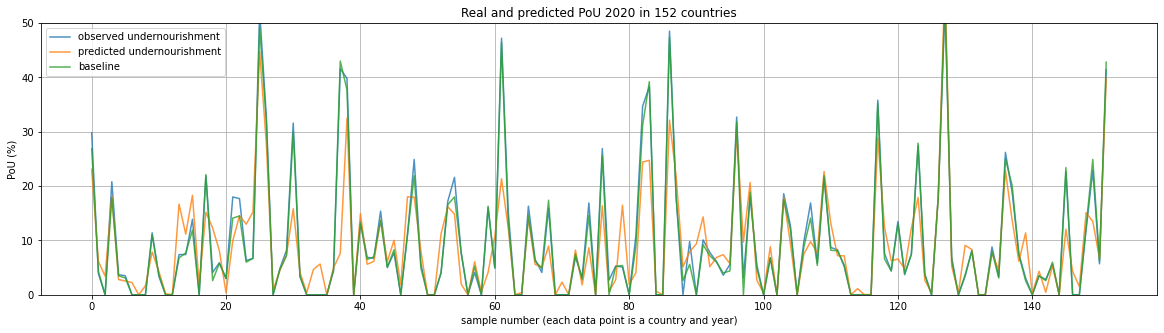

In [163]:
# plotting actual vs predicted undernourishment
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_result["Real Undernourishment"], alpha=0.8, label="observed undernourishment")
plt.plot(df_result["Pred. Undernourishment"],alpha=0.8, label="predicted undernourishment")
plt.plot(df_comp["Undernourishment (%)"],alpha=0.8, label="baseline")
plt.xlabel("sample number (each data point is a country and year)")
plt.ylabel("PoU (%)")
plt.legend(loc="upper left")
plt.title("Real and predicted PoU 2020 in 152 countries")
plt.ylim(0,50)
plt.grid()
plt.show()

<Figure size 432x288 with 0 Axes>

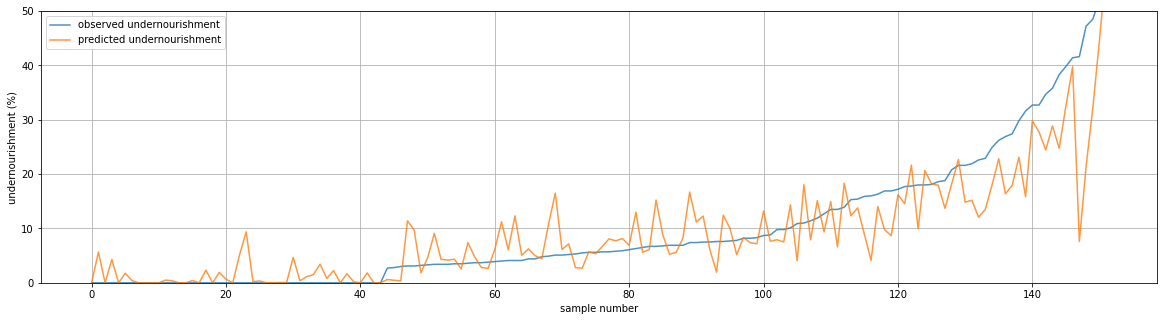

In [164]:
# same thing, but sorting the dataframe by ascending real PoU values first
df_asc = df_result.sort_values(by=["Real Undernourishment"]).reset_index()
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_asc["Real Undernourishment"], alpha=0.8, label="observed undernourishment")
plt.plot(df_asc["Pred. Undernourishment"],alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number")
plt.ylabel("undernourishment (%)")
plt.legend(loc="upper left")
plt.ylim(0,50)
plt.grid()
plt.show()